# chapter4. ニューラルネットの学習

> このサイトもイメージしやすくていいかも
> http://yaju3d.hatenablog.jp/entry/2016/04/21/022519

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## 4.1 データから学習する

「学習」とは訓練データから最適な重みパラメータの値を自動で獲得すること．
ニューラルネットを使った学習は，他の機械学習と大きく違って，人間のアイディアを介することなく学習を行うことができる．    
<img src="./fig/1.png" width=800 align="left">

## 4.2 損失関数(loss function)

### 二乗和誤差 $$ E = \frac{1}{2} \sum_{k}(y_k - t_k)^2 $$

※1/2する理由としては二乗和誤差を微分した際に係数である2が前に出てくる．実際に使用するときは微分係数を無視することがほとんどなので，だったら先に1/2してしまおうというのが理由

In [2]:
def mean_squared_error(y, t):
    return 0.5 * np.sum((y-t)**2)

In [3]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
mean_squared_error(np.array(y), np.array(t)) # 誤差がかなり小さい

0.09750000000000003

In [4]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0] 
mean_squared_error(np.array(y), np.array(t)) # 誤差が大きい

0.5975

### 交差エントロピー誤差 $$E = - \sum_k t_k \log y_k $$   

$y_k$はニューラルネットの出力，$t_k$は正解ラベルだがone-hot表現を使うため，正解ラベルのみ対応する出力の自然対数を計算する．情報理論において2つの確率分布の間に定義される尺度．(one-hot表現によって示された解がどれだけ正しいのかを図る関数?)

In [5]:
def cross_entropy_error(y, t):
    delta = 1e-7
    return -np.sum(t * np.log(y+delta))

/Users/intel0tw5727/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


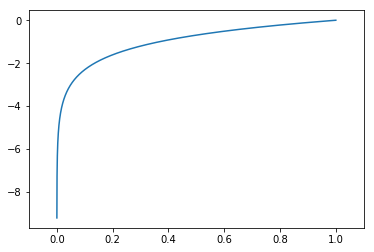

In [50]:
# logのグラフ
x = np.arange(0, 1, 0.0001)
y = np.log(x)
plt.plot(x,y)
plt.xlim(-0.1,1.1)
plt.show()

In [7]:
t = [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]
y = [0.1, 0.05, 0.6, 0.0, 0.05, 0.1, 0.0, 0.1, 0.0, 0.0]
cross_entropy_error(np.array(y), np.array(t)) # 誤差がかなり小さい

0.510825457099338

In [8]:
y = [0.1, 0.05, 0.1, 0.0, 0.05, 0.1, 0.0, 0.6, 0.0, 0.0] 
cross_entropy_error(np.array(y), np.array(t)) # 誤差が大きい

2.302584092994546

### ミニバッチ学習 $$E = - \frac{1}{N} \sum_n \sum_k t_{nk} \log{y_{nk}}$$    

訓練データに対する損失関数(loss関数)を求めて最小化していくのですべての訓練データを参照する必要がある．バッチ学習はn個のデータをまとめて計算して1個あたりの「平均の損失関数」を求める．つまるところ訓練データがどれだけあっても1個あたりの平均損失関数を求めるため1回の学習時間を高速化する．それをエポックごとにランダムにデータを選び直していく．このような学習手法をミニバッチ学習という．

In [9]:
from dataset.mnist import load_mnist

In [10]:
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

In [11]:
x_train.shape

(60000, 784)

In [12]:
t_train.shape

(60000, 10)

In [13]:
train_size = x_train.shape[0]
batch_size = 10
batch_mask = np.random.choice(train_size, batch_size)
x_batch = x_train[batch_mask]
t_batch = x_train[batch_mask]

In [14]:
batch_mask # 10個ランダムに選択

array([31820, 59282, 56818, 36649, 52023, 32931, 20105, 16557, 12688,
       48091])

### [batch対応版] 交差エントロピー誤差の実装

ニューラルネットワークにおける学習の際に，認識精度を指標にしてしまうと，パラメータ対する微分が殆どの場所で0を取ってしまうから．それをなんとかするために損失関数を別に用意し，その変化によってパラメータをどのように動かすかを判断することができる．   
認識精度というのはパラメータの微小な変化にほとんど変化を示さずに不連続に突然変化する．そこで活性化関数にシグモイド関数を用いて連続的に変化させることで，どの箇所で微分をしても傾きが0にならない．

In [15]:
def cross_entropy_error(y,t):
    if y.ndim == 1:
        t = t.reshape(1,t.size)
        y = y.reshape(1,y.size)
        
    batch_size = y.shape[0]
    return -np.sum(t * np.log(y)) / batch_size
    # return -np.sum(t * np.log(y[np.arrange(batch_size), t])) / batch_size  # ラベル表現の場合

In [16]:
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

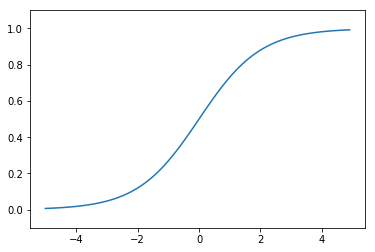

In [17]:
a = np.arange(-5.0,5.0,0.1)
b = sigmoid(a)
plt.ylim(-0.1,1.1)
plt.plot(a,b)
plt.show()

## 数値微分

In [59]:
def numerical_diff(f,x):
    h = 1e-8 # 0.0001
    return (f(x + h) - f(x-h)) / (2*h)

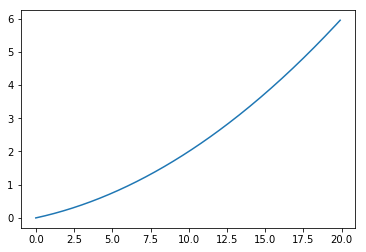

In [69]:
# Example
def function_1(x):
    return 0.01 * (x**2) + 0.1*x

x = np.arange(0,20,0.1)
y = function_1(x)
plt.plot(x,y)
plt.show()

In [72]:
# ほぼ一致
[[numerical_diff(function_1, _), 0.02 * _ + 0.1] for _ in range(10)]

[[0.1, 0.1],
 [0.11999999952050366, 0.12000000000000001],
 [0.1399999990936429, 0.14],
 [0.1600000021362291, 0.16],
 [0.1799999926888063, 0.18],
 [0.1999999943436137, 0.2],
 [0.22000000710065137, 0.22],
 [0.23999999765322855, 0.24000000000000002],
 [0.25999999930803597, 0.26],
 [0.2800000231673039, 0.28]]

## 偏微分

In [21]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [22]:
def function_tmp1(x0):
    return x0*x0 + 4.0 ** 2.0

In [23]:
numerical_diff(function_tmp1, 3.0)

6.00000000000378

In [24]:
def function_tmp2(x1):
    return 3.0**2.0 + x1*x1

In [25]:
numerical_diff(function_tmp2, 4.0)

7.999999999999119

## 勾配

In [26]:
def numerical_gradient(f,x):
    h=1e-4 # 0.0001
    grad = np.zeros_like(x) # xと同じ形状の配列の生成
    
    for idx in range(x.size):
        tmp_val = x[idx]
        # f(x+h) の計算
        x[idx] = tmp_val + h
        fxh1 = f(x)
        
        # f(x-h) の計算
        x[idx] = tmp_val - h
        fxh2 = f(x)
        
        grad[idx] = (fxh1 - fxh2) / (2*h)
        x[idx] = tmp_val
        
    return grad

In [27]:
numerical_gradient(function_2, np.array([3.0, 4.0]))

array([6., 8.])

In [28]:
numerical_gradient(function_2, np.array([0.0, 2.0]))

array([0., 4.])

### 勾配法

In [29]:
def gradient_descent(f, init_x, lr=0.01, step_num=100): # lr = leaning rate
    x = init_x
    
    for i in range(step_num):
        grad = numerical_gradient(f,x)
        x -= lr * grad
        
    return x

In [30]:
def function_2(x):
    return x[0]**2 + x[1]**2

In [31]:
init_x = np.array([-3.0,4.0])
gradient_descent(function_2, init_x=init_x, lr=0.1, step_num=100)

array([-6.11110793e-10,  8.14814391e-10])

学習率のようなパラメータのことを**ハイパーパラメータ**という．これは，ニューラルネットワークのパラメータである重みやバイアスとは性質の異なるパラメータで，人の手によって設定しなければならないものを指す．

### ニューラルネットワークによる勾配

In [32]:
import numpy as np
from common.functions import softmax, cross_entropy_error
from common.gradient import numerical_gradient

In [33]:
class simpleNet:
    def __init__(self):
        self.W = np.random.randn(2,3) # ガウス分布で初期化
        
    def predict(self, x):
        return np.dot(x, self.W)
    
    def loss(self, x, t):
        z = self.predict(x)
        y = softmax(z)
        loss = cross_entropy_error(y, t)
        
        return loss

In [34]:
net = simpleNet()

In [35]:
print(net.W)

[[ 0.1128068  -1.32982092  1.42783758]
 [-2.65549433  1.47528106  0.23162827]]


In [36]:
x = np.array([0.6, 0.9])
p = net.predict(x)
p

array([-2.32226082,  0.5298604 ,  1.06516799])

In [37]:
np.argmax(p)

2

In [38]:
t = np.array([0,0,1])
net.loss(x, t)

0.4819844669685841

In [39]:
def f(W):
    return net.loss(x, t)

In [40]:
dW = numerical_gradient(f, net.W)

In [41]:
dW 

array([[ 0.01252237,  0.21694364, -0.22946601],
       [ 0.01878355,  0.32541546, -0.34419901]])

In [42]:
dW = numerical_gradient(lambda w: net.loss(x, t), net.W)

In [43]:
dW

array([[ 0.01252237,  0.21694364, -0.22946601],
       [ 0.01878355,  0.32541546, -0.34419901]])

### 学習アルゴリズムの実装

1. ミニバッチ：trainデータの中からランダムに一分のデータを選ぶ
2. 勾配の算出：mini batchのloss function を減らすために，重みパラメータの勾配を求める
3. パラメータの更新：重みパラメータを勾配方向に微小量だけ更新する
4. 繰り返し： 1から3を繰り返す

1.の手順を採用している求め方を**確率的勾配降下法**と呼ぶ．多くのフレームワークでは**SGD**(Stomatic Gradient Descent)と呼ばれる．

In [44]:
import numpy as np
from common.functions import *
from common.gradient import numerical_gradient

In [45]:
class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size) 
        self.params['b2'] = np.zeros(output_size)
        
    def predict(self, x):
        W1,W2 = self.params['W1'], self.params['W2']
        b1, b2 = self.params['b1'], self.params['b2']
        
        a1 = np.dot(x, W1) + b1
        z1 = sigmoid(a1)
        a2 = np.dot(z1, W2) + b2
        y = softmax(a2)
        
        return y
        
    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        
        return cross_entropy_error(y, t)
    
    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1 : t = np.argmax(t, axis=1)
        
        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy
        
    # x:入力データ, t:教師データ
    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)
        
        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        
        return grads
        
    def gradient(self, x, t):
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.lastLayer.backward(dout)
        
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        grads['W1'], grads['b1'] = self.layers['Affine1'].dW, self.layers['Affine1'].db
        grads['W2'], grads['b2'] = self.layers['Affine2'].dW, self.layers['Affine2'].db

        return grads

In [46]:
net = TwoLayerNet(input_size=784, hidden_size=100, output_size=10)

In [47]:
print(net.params['W1'].shape)
print (net.params['b1'].shape)
print (net.params['W2'].shape)
print (net.params['b2'].shape)

(784, 100)
(100,)
(100, 10)
(10,)


In [48]:
x = np.random.rand(100, 784)
y = net.predict(x)

In [49]:
x = np.random.rand(100, 784)
t = np.random.rand(100, 10)

grads = net.numerical_gradient(x, t)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/intel0tw5727/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-49-ed25599258c5>", line 4, in <module>
    grads = net.numerical_gradient(x, t)
  File "<ipython-input-45-50374d167faf>", line 41, in numerical_gradient
    grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
  File "/Users/intel0tw5727/Desktop/Meetup010_3_Learning_Scratch_of_DL/common/gradient.py", line 46, in numerical_gradient
    fxh2 = f(x) # f(x-h)
  File "<ipython-input-45-50374d167faf>", line 38, in <lambda>
    loss_W = lambda W: self.loss(x, t)
  File "<ipython-input-45-50374d167faf>", line 24, in loss
    y = self.predict(x)
  File "<ipython-input-45-50374d167faf>", line 15, in predict
    a1 = np.dot(x, W1) + b1
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (mos

KeyboardInterrupt: 

### まとめ

+ 機械学習においてデータセットをtrain_dataとtest_dataに分ける
+ 訓練データで学習を行い，学習したモデルの汎化能力をテストデータで評価する．
+ ニューラルネットによる学習は1，loss functionを指標として，値が小さくなるように，重みパラメータを更新する
+ 重みパラメータを更新する際には，重みパラメータの勾配を利用して，勾配方向に重みの値を更新する作業を繰り返す．
+ 数値微分によって勾配が求まるが，時間がかかるため，5章における誤差逆伝播法を用いることで高速に勾配を求めることができる．